In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

In [3]:
from src.models import model

In [4]:
device = "cuda"

In [5]:
PINN = model.PINN_import("./results/2025-06-17_15-33-07/model_intermediate_model.pth", input_len=256, output_len=4, data_input=4, RFF = True, device = device)

In [6]:
datafile = "./data/periodic_data_cleaned.csv"

In [7]:
df = pd.read_csv(datafile)

In [8]:
df.describe()

,Time,point_id,Points:0,Points:1,Points:2,p,U:0,U:1,U:2
count,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07
mean,1.250000e+03,7.689500e+04,2.000000e+00,1.000000e+00,1.000000e+00,1.590331e-05,3.081454e-01,-6.297386e-06,-1.241456e-04
std,7.231298e+02,4.439564e+04,1.183216e+00,7.831043e-01,5.962848e-01,6.356747e-04,1.443003e-01,6.359226e-03,1.031086e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.385121e-03,-8.813336e-03,-1.204620e-01,-1.552387e-01
25%,6.250000e+02,3.844700e+04,1.000000e+00,1.629123e-01,4.666667e-01,-9.548649e-05,2.039667e-01,-6.542691e-04,-1.708895e-03
50%,1.250000e+03,7.689500e+04,2.000000e+00,1.000000e+00,1.000000e+00,-1.415304e-09,3.637780e-01,0.000000e+00,0.000000e+00
75%,1.875000e+03,1.153430e+05,3.000000e+00,1.837088e+00,1.533333e+00,1.319332e-04,4.216372e-01,6.422824e-04,1.228451e-03
max,2.500000e+03,1.537900e+05,4.000000e+00,2.000000e+00,2.000000e+00,1.199402e-02,5.526472e-01,1.126035e-01,1.541705e-01


In [9]:
horizon = df.loc[np.abs(df["Points:0"])==0.].reset_index()
horizon = horizon[horizon["Points:2"]==0.]

In [10]:
time = np.random.randint(80, 150)

In [11]:
horizon = horizon[horizon["Time"]==time*10]

In [12]:
horizon = horizon[horizon["Points:1"]>1.5]

In [13]:
horizon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 665830 to 665877
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     48 non-null     int64  
 1   Time      48 non-null     float64
 2   point_id  48 non-null     int64  
 3   Points:0  48 non-null     float64
 4   Points:1  48 non-null     float64
 5   Points:2  48 non-null     float64
 6   p         48 non-null     float64
 7   U:0       48 non-null     float64
 8   U:1       48 non-null     float64
 9   U:2       48 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 4.1 KB


In [14]:
y_axis = horizon["Points:1"].values
u_x = horizon["U:0"].values
x_axis = horizon["Points:0"].values
abs_x_axis = np.abs(x_axis)

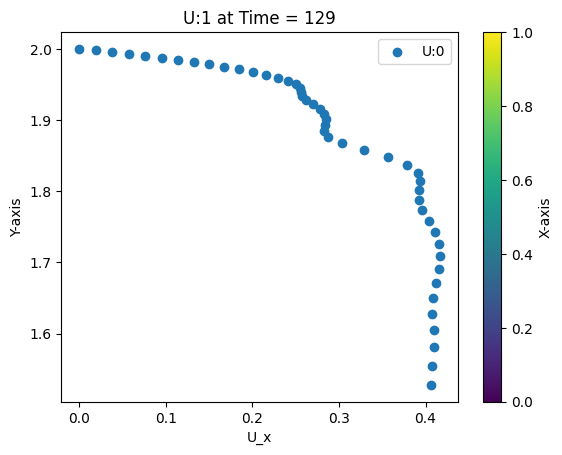

In [15]:
plt.scatter(u_x, y_axis, label="U:0")
plt.xlabel("U_x")
plt.ylabel("Y-axis")
plt.title("U:1 at Time = {}".format(time))
plt.legend()
plt.colorbar(label="X-axis")
plt.show()

In [16]:
import src.tools.util_func as util_func

In [17]:
forward_transform_input, forward_transform_output, inverse_transform_input, inverse_transform_output, Re = util_func.get_ND_non_dim(datafile, df, 2e-5)

Non-dimensionalization parameters:
Length scale (L): 1.8683925867080688
Velocity scale (U_hat): 0.17297884821891785
Time scale (T_hat): 10.801278114318848
Reynolds number (Re): 16159.619390964506


In [18]:
Y_range = torch.linspace(0., 2., 100)
## give me a tensor of (0., Y_range, time) knowing that Y_range is a tensor of shape (100,)
X_axis = 1. * torch.ones((Y_range.shape[0]))
Z_axis = 1. * torch.ones((Y_range.shape[0]))
time_axis = 1.  * torch.ones((Y_range.shape[0]))

input_tensor = torch.stack((time_axis, X_axis, Y_range, Z_axis), dim=1)
input_tensor_np = input_tensor.numpy()
input_tensor = forward_transform_input(input_tensor)
input_tensor = torch.tensor(input_tensor_np, dtype=torch.float32)
input_tensor = input_tensor.to(device)

In [19]:
PINN = PINN.to(device)

In [20]:
U_x_pred = PINN(input_tensor)

In [21]:
y_axis = input_tensor[:, 2].cpu().detach().numpy()
u_x_pred = inverse_transform_output(U_x_pred.cpu().detach().numpy())
u_x_axis = u_x_pred[:, 0]
print(u_x_axis)

[ 0.4101809   0.41238335  0.41443843  0.4163464   0.41810784  0.419723
  0.42119226  0.42251611  0.42369479  0.42472905  0.42561904  0.426366
  0.42697042  0.42743224  0.42775172  0.42792895  0.42796335  0.42785391
  0.42759994  0.42719939  0.42665082  0.42595184  0.42510039  0.42409343
  0.42292854  0.42160246  0.42011198  0.4184545   0.41662651  0.41462457
  0.41244555  0.41008556  0.40754056  0.40480632  0.40187803  0.3987506
  0.39541805  0.39187402  0.38811207  0.3841247   0.37990421  0.37544262
  0.37073106  0.36576065  0.36052209  0.35500571  0.34920159  0.34309989
  0.33669004  0.32996175  0.32290474  0.31550807  0.30776143  0.29965359
  0.29117417  0.28231221  0.2730577   0.26340047  0.2533316   0.24284379
  0.23193167  0.22059277  0.20882986  0.19665059  0.18406938  0.17110756
  0.15779217  0.14415598  0.13023812  0.11608341  0.1017421   0.08726877
  0.07271923  0.05814886  0.04360701  0.02913071  0.01473894  0.00043101
 -0.01380971 -0.02800193 -0.04215212 -0.05624272 -0.0702

/tmp/ipykernel_4065756/444733591.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


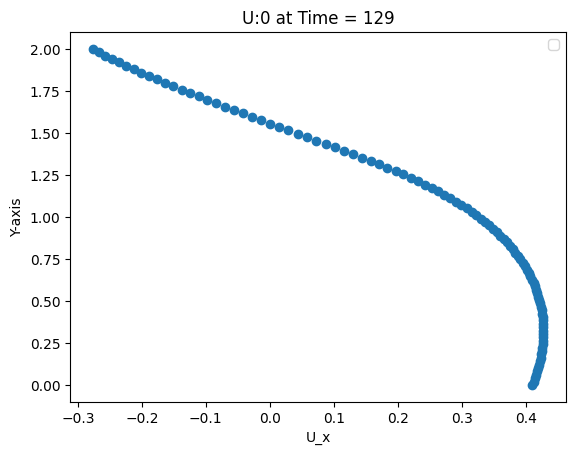

In [22]:
plt.scatter(u_x_axis, y_axis,)
plt.xlabel("U_x")
plt.ylabel("Y-axis")
plt.title("U:0 at Time = {}".format(time))
plt.legend()
plt.show()

## Annex stuff

In [23]:
from src.data_process.load_data import import_data
import src.tools.plot_tools as plot_tools

In [24]:
x, y = import_data(datafile, df, forward_transform_input, forward_transform_output)

In [25]:
x = torch.tensor(x, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.float32, device=device)

In [26]:
t, _, _, _ = forward_transform_input(np.array([time, 1., 0., 1.]))

In [27]:
t

-104.01553598851346

In [28]:
x[:, 0]

tensor([-115.4957, -115.4957, -115.4957,  ...,  -70.1307,  -70.1307,
         -70.1307], device='cuda:0')

In [38]:
indx = torch.where(torch.abs(x[:, 0] - t) < 0.5)
x_time = x[indx]
y_time = y[indx]

In [39]:
x_time[:, 0].unique()

tensor([-104.3859, -103.9230], device='cuda:0')

In [31]:
pred_all = PINN(x_time.to(device))
mse = nn.MSELoss()
loss = mse(pred_all, y_time.to(device))
print("MSE Loss: ", loss.item())

OutOfMemoryError: CUDA out of memory. Tried to allocate 602.00 MiB. GPU 0 has a total capacity of 23.54 GiB of which 45.12 MiB is free. Process 3869604 has 10.97 GiB memory in use. Including non-PyTorch memory, this process has 12.46 GiB memory in use. Of the allocated memory 11.72 GiB is allocated by PyTorch, and 305.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
x_min, x_max = 0., 4.
y_min, y_max = 0., 2.
x_ax = np.linspace(x_min, x_max, 100)  # Spatial grid (x)
y_ax = np.linspace(y_min, y_max, 100)  # Spatial grid (y)
t = np.linspace(0, 100, 100)   # Time grid

# Create meshgrid for plotting
X, Y = np.meshgrid(x_ax, y_ax)

In [ ]:
sampled_z = np.unique(x[:, 3])
sampled_z = sampled_z[0]

In [ ]:
plot_tools.plot_speed_map(
        model=PINN,
        X=X,
        Y=Y,
        t=t,
        save_dir="",
        device=device,
        non_dim=True,
        forward_transform_input=forward_transform_input,
        inverse_transform_output=inverse_transform_output,
        additional_name="_intermediate_model",
        sample_z=sampled_z,
    )